In [1]:
input_address = input('Input image address:') #input must be in "" ("test.jpg" if file is in project folder),
                                              #acceptable formats: .jpg, .jpeg, .png, .gif, .bmp

Input image address:"test.png"


In [2]:
#INTERFACE
#Modes
ahash_mode  = 1 #compare ahashes
phash_mode  = 1 #compare phashes
dhash_mode  = 1 #compare dhashes
ncc_mode    = 1 #find normalized cross correlation

pix_mode    = 0 #compare per-pixel (FOR TESTS ONLY)
                #Quite effectively to a binary image. 
                #To grayscale need to use something to check the value of pixels rather than quantity. 
                #Perhaps: Levenshtein distance, MSE, RMSE, etc.

#Options
threshold   = 10    
t_threshold = 50    #delete finded symbol if number of black pixels < threshold
black_mode  = 0     #compare only black pixels
bin_ratio   = 600   #binarization threshold (0-255*3)
resize_mode = 1     #none = 0, antialias = 1, bicubic = 2 (0 IS NOT RECOMMENDED)
basewidth   = 8     #image width after compression (px)
hashing_mode = 'md5'#md5, sha1, sha224, sha256, sha384, sha512

rotate_mode = 0     #comrape with rotated examples (NOT RECOMMENDED)
rotate_degr = 87    #the degree to which the image is rotated by one step, 
                    #it will be approximated to integer number of steps for the passage of a circle.
    
from PIL import Image, ImageDraw
import os, hashlib, functools, scipy.fftpack, numpy, glob, operator, ImageChops, math, ImageFilter
from IPython.display import display, Image as DImage
#Creating folders
#The folder where the user places the samples to be compared to the incoming image.
#Acceptable formats: .jpg, .jpeg, .png, .gif, .bmp
if not os.path.exists(os.getcwd()+'/examples/'):
    os.mkdir('examples')
examples_path = os.getcwd()+'/examples/'
#The folder in which the binary images will be generated.
if not os.path.exists(os.getcwd()+'/binary/'):
    os.mkdir('binary')
binary_path = os.getcwd()+'/binary/'
#The folder in which the finded symbols will be generated.
if not os.path.exists(os.getcwd()+'/finded/'):
    os.mkdir('/finded/')
finded_path = os.getcwd()+'/finded/'

#Global variables.
names   = []
values  = []
results = []
ahashes = []
phashes = []
dhashes = []
nccors  = []

RESULT = ''

In [3]:
def clean_folders():
    #Cleaning folders
    #The folder in which the binary images will be generated.
    if os.path.exists(os.getcwd()+'/binary/'):   
        filelist = glob.glob(os.getcwd()+'/binary/*.*')
        for f in filelist:
            os.remove(f)
    #The folder in which the finded symbols will be generated.
    if os.path.exists(os.getcwd()+'/finded/'):
        filelist = glob.glob(os.getcwd()+'/finded/*.*')
        for f in filelist:
            os.remove(f)

In [4]:
def address_helper(input_img_addr, mode):
    if mode == 'png': #after preprocessing the program only works with .png format in order to avoid loss of quality
        input_img_addr = input_img_addr.replace('.jpg','.png')
        input_img_addr = input_img_addr.replace('.jpeg','.png')
        input_img_addr = input_img_addr.replace('.gif','.png')
        input_img_addr = input_img_addr.replace('.bmp','.bmp')
    if mode == 'bin': #change the address of the folder to /binary
        input_img_addr = input_img_addr.replace('/examples/','/binary/')
    if mode == 'cln': #leave only the name of file (letter)
        if rotate_mode == 1:
            for i in range(1, abs(360 / rotate_degr)):
                input_img_addr = input_img_addr.replace(str(360 / abs(360 / rotate_degr)*(i))+'.','.')
        input_img_addr = input_img_addr.replace('.jpg','')
        input_img_addr = input_img_addr.replace('.jpeg','')
        input_img_addr = input_img_addr.replace('.gif','')
        input_img_addr = input_img_addr.replace('.png','')
        input_img_addr = input_img_addr.replace('.bmp','')
        input_img_addr = input_img_addr.replace(binary_path,'')
        input_img_addr = input_img_addr.replace(finded_path,'')
    
    return input_img_addr

In [5]:
def binarization(input_img_addr):
    input_image  = Image.open(input_img_addr).convert('RGB') #convert for .gif opening fix
    draw = ImageDraw.Draw(input_image)
     
    for i in range(input_image.size[0]):
        for j in range(input_image.size[1]):
            r, g, b = input_image.getpixel((i,j))
            if (r + g + b > bin_ratio): 
                r, g, b = 255, 255, 255 #draw pixel black
            else:
                r, g, b = 0, 0, 0       #draw pixel white
            draw.point((i, j), (r, g, b))
    del draw
    #save in /binary folder like name.png
    input_img_addr = address_helper(input_img_addr,'png')
    input_image.save(address_helper(input_img_addr,'bin'), "PNG")

In [6]:
def save_rotate(input_img_addr, rotate_degr):  
    input_img_addr = address_helper(input_img_addr,'png')
    #first step out of cycle, becouse of don't want disposable checking in cycle
    (Image.open(input_img_addr).rotate(rotate_degr) #rotate first step
     .save(input_img_addr.replace('.',str(rotate_degr)+'.'), "PNG"))  #save first step
    input_img_addr = input_img_addr.replace('.',str(rotate_degr)+'.') #first step, str(...*(i-1)) returns '0'
    
    for i in range(2, 360 / rotate_degr):
        input_image = Image.open(input_img_addr).rotate(rotate_degr) 
        input_img_addr = input_img_addr.replace(str((rotate_degr)*(i-1))+'.',
                                                str((rotate_degr)*i)+'.')
        input_image.save(input_img_addr, "PNG")

In [7]:
def resize(input_img_addr, basewidth):#preprocessing for hashes
    input_image = Image.open(input_img_addr)
    height = int((float(input_image.size[1]) * 
                 float(basewidth / float(input_image.size[0])))) #calculate the proportional height
    if resize_mode == 1:
        input_image = input_image.resize((basewidth,height), Image.ANTIALIAS)
    if resize_mode == 2:
        input_image = input_image.resize((basewidth,height), Image.BICUBIC)
    else:
        input_image = input_image.resize((basewidth,height))
    input_image.save(address_helper(input_img_addr,'res'), "PNG")

In [8]:
def separation(input_img_addr, threshold):
    x0 = 0
    y0 = 0
    x1 = 0
    y0 = 0

    symbolsx = []
    symbolsy = []

    black    = False
    symbol = False
    
    input_image = Image.open(input_img_addr).convert('L')
    
    for x in xrange(input_image.size[0]):
        for y in xrange(input_image.size[1]):
            pix = input_image.getpixel((x,y))
            if pix < 255:
                black += 1
        if symbol == False and black > threshold: 
            x0 = x
            symbol = True
        if symbol == True and black <= threshold:
            x1 = x
            symbol = False
            symbolsx.append((x0, x1))
        black = 0
    
    black    = False
    symbol = False
        
    for y in xrange(input_image.size[1]):
        for x in xrange(input_image.size[0]):
            pix = input_image.getpixel((x,y))
            if pix < 255:
                black += 1
        if symbol == False and black > threshold:
            y0 = y
            symbol = True
        if symbol == True and black <= threshold:
            y1 = y
            symbol = False
            symbolsy.append((y0, y1))
        black = 0
    
    count = 0
    black = 0
    
    if symbolsx == []:
        symbolsx = [(0,input_image.size[0])] 
    if symbolsy == []:
        symbolsy = [(0,input_image.size[1])] 
        
    for y in symbolsy:
        for x in symbolsx:
            if count < 1000:
                temp = '{:03d}'.format(count)                  
                input_image.crop((x[0],y[0],x[1],y[1])).save('finded/'+str(temp)+'.png', "PNG")
            count += 1

In [9]:
def delete_trash(threshold):
    images = os.listdir(finded_path)
    for i in range(len(images)):
        try:
            black = 0
            input_image = Image.open(finded_path+images[i])
            
            for x in xrange(input_image.size[0]):
                for y in xrange(input_image.size[1]):
                    pix = input_image.getpixel((x,y))
                    if pix != 255:
                        black += 1
            if black < threshold:
                os.remove(finded_path+images[i])
        except IOError:
            pass        

In [10]:
def pix_compare(input_img_addr, example_addr):
    input_image = Image.open(input_img_addr)
    input_pixels = input_image.load()
    example = Image.open(example_addr).resize((input_image.size[0],input_image.size[1]), Image.ANTIALIAS)
    true = 0 #number of equal pixels
    
    for i in range(0, input_image.size[0]):
        for j in range(0, input_image.size[1]):
            input_pixel = input_image.getpixel((i, j))
            example_pixel = example.getpixel((i, j))
            if input_pixel == example_pixel:                        
                if not (black_mode == 1 and input_pixels[i, j][0] == 0):
                    true+=1  
    return true

In [11]:
def ncc(input_img_addr, example_addr):
    #based on syntacticbayleaves.com/2008/12/03/determining-image-similarity/  
    input_image = Image.open(input_img_addr)
    example = Image.open(example_addr).resize((input_image.size[0],input_image.size[1]), Image.ANTIALIAS)
    
    images = [input_image, example]
    vectors = []
    norms = []
    for image in images:
        vector = []
        for pixel in image.getdata():
            vector.append(numpy.mean(pixel))
        vectors.append(vector)
        norms.append(numpy.linalg.norm(vector, 2))
    a, b = vectors
    a_norm, b_norm = norms
    res = numpy.dot(a / a_norm, b / b_norm)
    return res

In [12]:
def ham_dist(input_img_hash, example_hash):
    distance = 0
    #compare character by character
    for input_char, example_char in zip(input_img_hash, example_hash):
        if input_char != example_char:
            distance += 1
    return distance

In [13]:
def ahash(input_img_addr):
    #from ImageHash lib
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata()).reshape((basewidth, basewidth))
    avg = pixels.mean()
    diff = ''
    tmp = pixels > avg
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [14]:
def phash(input_img_addr):
    #from ImageHash lib
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata(), dtype = numpy.float).reshape((basewidth, basewidth))
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dct_low_freq = dct[:basewidth, :basewidth]
    med = numpy.median(dct_low_freq)
    diff = ''
    tmp = dct_low_freq > med
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [15]:
def dhash(input_img_addr):
    #from ImageHash lib
    # resize(w, h), but numpy.array((h, w))
    image = Image.open(input_img_addr).convert('L').resize((basewidth, basewidth))
    pixels = numpy.array(image.getdata(), dtype=numpy.float).reshape((basewidth, basewidth))
    # compute differences between rows
    diff = ''
    tmp = pixels[:, 1:] > pixels[:, :-1]
    for i in range(0, basewidth-1):
        for j in range(0, basewidth-1):
            if tmp[i,j] == True:
                diff+='1'
            else:
                diff+='0'    
    return diff

In [16]:
def compare_1to1(input_img_addr, example_addr):
    example_addr = binary_path + address_helper(example_addr,'png')
    input_img_addr = finded_path + input_img_addr
    
    
    #compare per-pixel
    if pix_mode == 1:      
        values.append(pix_compare(input_img_addr, example_addr))
        
    #normalized cross correlation
    if ncc_mode == 1:
        nccors.append(ncc(input_img_addr, example_addr))
        
    #resize(input_img_addr, basewidth)
    #resize(example_addr, basewidth)
    #example_addr = address_helper(example_addr,'res')
    #input_img_addr = address_helper(input_img_addr,'res')
    
    
    
    #WARNING:now pictures are resized
    #compare ahashes
    if ahash_mode == 1:
        ahashes.append(ham_dist(ahash(input_img_addr), ahash(example_addr)))
    #compare phashes
    if phash_mode == 1:
        phashes.append(ham_dist(phash(input_img_addr), phash(example_addr)))
    #compare dhashes
    if dhash_mode == 1:
        dhashes.append(ham_dist(dhash(input_img_addr), dhash(example_addr)))

    
    names.append(address_helper(example_addr, 'cln'))   

In [17]:
def compare_1toN(input_img_addr):
    #delete previous values
    global names, values, ahashes, phashes, dhashes, nccors
    names, values, ahashes, phashes, dhashes, nccors = [],[],[],[],[],[]
        
    examples = os.listdir(examples_path) #get list of all files in /examples
    for i in range(len(examples)):
        try: #check if file is image
            binarization(examples_path+examples[i])
            if rotate_mode == 1:
                save_rotate(binary_path+examples[i],360 / abs(360 / rotate_degr)) #rotate to the approximate degree
        except IOError:
            pass
    examples = os.listdir(binary_path) #get list of all files in /binary + rotated images
    for i in range(len(examples)):
        try: #check if file is image
            compare_1to1(input_img_addr,examples[i])
        except IOError:
            pass

In [18]:
def result_1toN():#rewrite for top-3 statistics
    global results #local results
    global RESULT  #global result
    results = [''] #clean prev result
    
    #collecting all the local results
    if pix_mode == 1 and values != []:
        results.append(names[values.index(max(values))])
    if ahash_mode == 1 and ahashes != []:
        results.append(names[ahashes.index(min(ahashes))])
    if phash_mode == 1 and phashes != []:
        results.append(names[phashes.index(min(phashes))])
    if dhash_mode == 1 and dhashes != []:
        results.append(names[dhashes.index(min(dhashes))])
    if ncc_mode == 1 and nccors != []:
        results.append(names[nccors.index(min(nccors))])
    RESULT += max(set(results), key=results.count) #add the most likely local result to the global

In [19]:
def print_1toN(): #developer function, NEWER EVER USE TO THE FULL DATASET
    if pix_mode == 1:
        print('Pixel mode:')
        for i in range(len(names)):
            print(names[i],values[i])
    if ahash_mode == 1:
        print('AHash mode:')
        for i in range(len(names)):
            print(names[i],ahashes[i])
    if phash_mode == 1:
        print('PHash mode:')
        for i in range(len(names)):
            print(names[i],phashes[i])
    if dhash_mode == 1:
        print('DHash mode:')
        for i in range(len(names)):
            print(names[i],dhashes[i])
    if ncc_mode == 1:
        print('NCC mode:')
        for i in range(len(names)):
            print(names[i],nccors[i])
    print('Results:')
    if pix_mode == 1 and values != []:
        print('Pixel mode:'+str(names[values.index(max(values))]))
    if ahash_mode == 1 and ahashes != []:
        print('AHash mode:'+str(names[ahashes.index(min(ahashes))]))
    if phash_mode == 1 and phashes != []:
        print('PHash mode:'+str(names[phashes.index(min(phashes))]))
    if dhash_mode == 1 and dhashes != []:
        print('DHash mode:'+str(names[dhashes.index(min(dhashes))]))
    if ncc_mode == 1 and nccors != []:
        print('NCC mode:'+str(names[nccors.index(max(nccors))]))
    print('Result:'+str(RESULT))

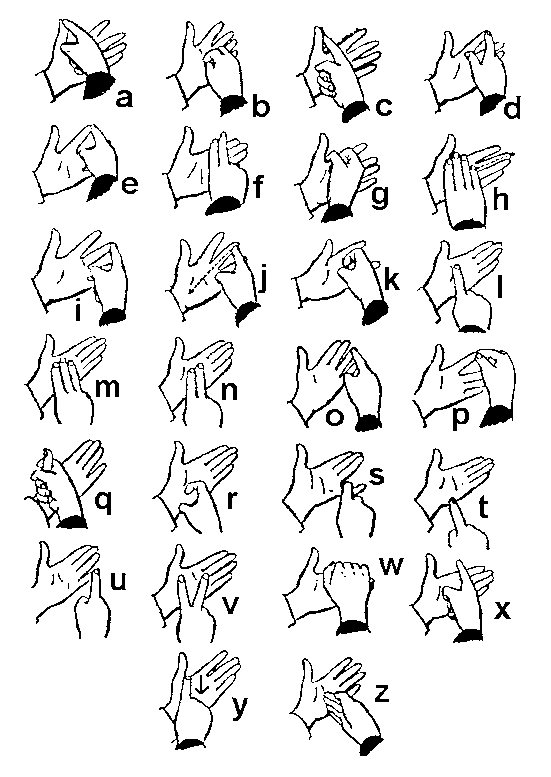

Processing:


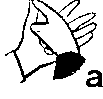

AHash mode:
('d', 12)
('x', 17)
('h', 11)
('n', 15)
('v', 9)
('k', 11)
('g', 13)
('y', 12)
('t', 15)
('j', 14)
('a', 0)
('b', 10)
('u', 12)
('p', 12)
('r', 12)
('e', 11)
('l', 14)
('o', 15)
('s', 11)
('w', 12)
('m', 12)
('z', 13)
('c', 13)
('i', 13)
('q', 16)
('f', 14)
PHash mode:
('d', 22)
('x', 29)
('h', 22)
('n', 24)
('v', 20)
('k', 19)
('g', 26)
('y', 24)
('t', 27)
('j', 21)
('a', 0)
('b', 25)
('u', 28)
('p', 26)
('r', 22)
('e', 15)
('l', 25)
('o', 23)
('s', 24)
('w', 27)
('m', 23)
('z', 21)
('c', 26)
('i', 26)
('q', 26)
('f', 26)
DHash mode:
('d', 9)
('x', 14)
('h', 9)
('n', 13)
('v', 11)
('k', 12)
('g', 13)
('y', 10)
('t', 15)
('j', 12)
('a', 0)
('b', 8)
('u', 9)
('p', 9)
('r', 10)
('e', 12)
('l', 12)
('o', 13)
('s', 9)
('w', 12)
('m', 10)
('z', 11)
('c', 13)
('i', 11)
('q', 14)
('f', 10)
NCC mode:
('d', 0.85895748912677905)
('x', 0.85072449023466279)
('h', 0.86069615285060463)
('n', 0.87865185084622921)
('v', 0.87021965042751737)
('k', 0.85556782822287869)
('g', 0.87178909666525

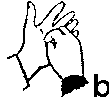

AHash mode:
('d', 10)
('x', 11)
('h', 7)
('n', 11)
('v', 11)
('k', 11)
('g', 9)
('y', 10)
('t', 11)
('j', 10)
('a', 10)
('b', 0)
('u', 8)
('p', 8)
('r', 10)
('e', 11)
('l', 12)
('o', 13)
('s', 9)
('w', 10)
('m', 6)
('z', 11)
('c', 11)
('i', 9)
('q', 12)
('f', 10)
PHash mode:
('d', 23)
('x', 22)
('h', 21)
('n', 21)
('v', 29)
('k', 18)
('g', 21)
('y', 25)
('t', 18)
('j', 24)
('a', 25)
('b', 0)
('u', 17)
('p', 23)
('r', 27)
('e', 22)
('l', 20)
('o', 28)
('s', 23)
('w', 22)
('m', 16)
('z', 22)
('c', 19)
('i', 17)
('q', 25)
('f', 29)
DHash mode:
('d', 9)
('x', 10)
('h', 7)
('n', 9)
('v', 9)
('k', 10)
('g', 9)
('y', 8)
('t', 9)
('j', 8)
('a', 8)
('b', 0)
('u', 5)
('p', 5)
('r', 8)
('e', 8)
('l', 10)
('o', 13)
('s', 7)
('w', 8)
('m', 6)
('z', 7)
('c', 9)
('i', 7)
('q', 10)
('f', 8)
NCC mode:
('d', 0.89809458791133256)
('x', 0.87786316747734505)
('h', 0.87801087784778886)
('n', 0.89344704188732127)
('v', 0.88068416432191254)
('k', 0.89090744431000424)
('g', 0.88512954177102132)
('y', 0.8804198

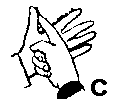

AHash mode:
('d', 9)
('x', 10)
('h', 10)
('n', 6)
('v', 6)
('k', 10)
('g', 8)
('y', 13)
('t', 10)
('j', 9)
('a', 13)
('b', 11)
('u', 9)
('p', 7)
('r', 9)
('e', 10)
('l', 9)
('o', 12)
('s', 4)
('w', 7)
('m', 13)
('z', 8)
('c', 0)
('i', 4)
('q', 13)
('f', 11)
PHash mode:
('d', 26)
('x', 19)
('h', 30)
('n', 22)
('v', 16)
('k', 27)
('g', 18)
('y', 22)
('t', 21)
('j', 27)
('a', 26)
('b', 19)
('u', 24)
('p', 24)
('r', 22)
('e', 25)
('l', 27)
('o', 23)
('s', 20)
('w', 15)
('m', 27)
('z', 25)
('c', 0)
('i', 18)
('q', 24)
('f', 26)
DHash mode:
('d', 8)
('x', 9)
('h', 10)
('n', 6)
('v', 6)
('k', 9)
('g', 8)
('y', 13)
('t', 10)
('j', 7)
('a', 13)
('b', 9)
('u', 8)
('p', 6)
('r', 9)
('e', 9)
('l', 9)
('o', 12)
('s', 4)
('w', 7)
('m', 11)
('z', 6)
('c', 0)
('i', 4)
('q', 13)
('f', 9)
NCC mode:
('d', 0.87517346891921266)
('x', 0.89011385077640726)
('h', 0.88196768672851966)
('n', 0.88448220253190224)
('v', 0.88439169436035969)
('k', 0.86917654896174557)
('g', 0.88157781933713175)
('y', 0.87034157700

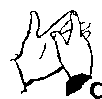

AHash mode:
('d', 0)
('x', 13)
('h', 7)
('n', 11)
('v', 7)
('k', 11)
('g', 11)
('y', 12)
('t', 13)
('j', 10)
('a', 12)
('b', 10)
('u', 10)
('p', 8)
('r', 8)
('e', 15)
('l', 10)
('o', 15)
('s', 9)
('w', 10)
('m', 12)
('z', 7)
('c', 9)
('i', 9)
('q', 12)
('f', 10)
PHash mode:
('d', 0)
('x', 27)
('h', 20)
('n', 24)
('v', 22)
('k', 21)
('g', 30)
('y', 26)
('t', 19)
('j', 27)
('a', 22)
('b', 23)
('u', 26)
('p', 28)
('r', 20)
('e', 25)
('l', 19)
('o', 27)
('s', 26)
('w', 27)
('m', 25)
('z', 19)
('c', 26)
('i', 22)
('q', 24)
('f', 18)
DHash mode:
('d', 0)
('x', 11)
('h', 6)
('n', 10)
('v', 6)
('k', 9)
('g', 10)
('y', 11)
('t', 12)
('j', 7)
('a', 9)
('b', 9)
('u', 8)
('p', 6)
('r', 9)
('e', 13)
('l', 9)
('o', 14)
('s', 8)
('w', 9)
('m', 11)
('z', 6)
('c', 8)
('i', 8)
('q', 11)
('f', 9)
NCC mode:
('d', 1.0000000000000029)
('x', 0.86750185506442867)
('h', 0.88516656759973866)
('n', 0.89130537853447933)
('v', 0.88379013458867139)
('k', 0.90367487847580663)
('g', 0.88857601555473931)
('y', 0.88495

AHash mode:
('d', 6)
('x', 7)
('h', 5)
('n', 5)
('v', 5)
('k', 9)
('g', 5)
('y', 8)
('t', 9)
('j', 6)
('a', 10)
('b', 6)
('u', 4)
('p', 2)
('r', 4)
('e', 9)
('l', 6)
('o', 9)
('s', 3)
('w', 4)
('m', 8)
('z', 7)
('c', 5)
('i', 3)
('q', 10)
('f', 6)
PHash mode:
('d', 21)
('x', 22)
('h', 25)
('n', 23)
('v', 21)
('k', 22)
('g', 23)
('y', 25)
('t', 22)
('j', 26)
('a', 23)
('b', 20)
('u', 23)
('p', 23)
('r', 23)
('e', 26)
('l', 24)
('o', 24)
('s', 23)
('w', 24)
('m', 24)
('z', 24)
('c', 21)
('i', 21)
('q', 25)
('f', 25)
DHash mode:
('d', 5)
('x', 6)
('h', 5)
('n', 5)
('v', 5)
('k', 6)
('g', 5)
('y', 8)
('t', 9)
('j', 4)
('a', 8)
('b', 4)
('u', 3)
('p', 1)
('r', 4)
('e', 8)
('l', 6)
('o', 9)
('s', 3)
('w', 4)
('m', 6)
('z', 5)
('c', 5)
('i', 3)
('q', 10)
('f', 4)
NCC mode:
('d', 0.89878218301987933)
('x', 0.87975039929258314)
('h', 0.87261532055836188)
('n', 0.85835848823387684)
('v', 0.85632009691873312)
('k', 0.86291096284136082)
('g', 0.88168811892111343)
('y', 0.87423115776809002)
('t', 0

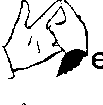

AHash mode:
('d', 15)
('x', 16)
('h', 14)
('n', 12)
('v', 10)
('k', 10)
('g', 12)
('y', 13)
('t', 14)
('j', 13)
('a', 11)
('b', 11)
('u', 11)
('p', 11)
('r', 13)
('e', 0)
('l', 15)
('o', 16)
('s', 10)
('w', 7)
('m', 9)
('z', 12)
('c', 10)
('i', 12)
('q', 13)
('f', 15)
PHash mode:
('d', 25)
('x', 30)
('h', 21)
('n', 27)
('v', 21)
('k', 22)
('g', 27)
('y', 19)
('t', 20)
('j', 28)
('a', 15)
('b', 22)
('u', 23)
('p', 27)
('r', 21)
('e', 0)
('l', 28)
('o', 26)
('s', 21)
('w', 22)
('m', 18)
('z', 24)
('c', 25)
('i', 31)
('q', 21)
('f', 23)
DHash mode:
('d', 13)
('x', 14)
('h', 13)
('n', 11)
('v', 11)
('k', 10)
('g', 13)
('y', 12)
('t', 13)
('j', 12)
('a', 12)
('b', 8)
('u', 9)
('p', 9)
('r', 12)
('e', 0)
('l', 14)
('o', 15)
('s', 9)
('w', 6)
('m', 8)
('z', 9)
('c', 9)
('i', 11)
('q', 12)
('f', 12)
NCC mode:
('d', 0.88396128896195536)
('x', 0.87920141531837093)
('h', 0.88145627757923517)
('n', 0.91076544837259066)
('v', 0.90145980960559058)
('k', 0.883185610038701)
('g', 0.88959235817778015)


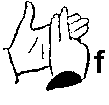

AHash mode:
('d', 10)
('x', 13)
('h', 9)
('n', 11)
('v', 9)
('k', 13)
('g', 11)
('y', 12)
('t', 11)
('j', 12)
('a', 14)
('b', 10)
('u', 10)
('p', 6)
('r', 10)
('e', 15)
('l', 12)
('o', 13)
('s', 9)
('w', 8)
('m', 14)
('z', 11)
('c', 11)
('i', 9)
('q', 12)
('f', 0)
PHash mode:
('d', 18)
('x', 27)
('h', 22)
('n', 28)
('v', 18)
('k', 21)
('g', 28)
('y', 24)
('t', 21)
('j', 27)
('a', 26)
('b', 29)
('u', 22)
('p', 30)
('r', 26)
('e', 23)
('l', 23)
('o', 21)
('s', 22)
('w', 21)
('m', 25)
('z', 21)
('c', 26)
('i', 26)
('q', 18)
('f', 0)
DHash mode:
('d', 9)
('x', 10)
('h', 9)
('n', 9)
('v', 9)
('k', 8)
('g', 9)
('y', 10)
('t', 11)
('j', 8)
('a', 10)
('b', 8)
('u', 7)
('p', 3)
('r', 8)
('e', 12)
('l', 10)
('o', 11)
('s', 7)
('w', 6)
('m', 10)
('z', 9)
('c', 9)
('i', 7)
('q', 14)
('f', 0)
NCC mode:
('d', 0.8891486821974357)
('x', 0.87991082505113105)
('h', 0.87655078592416058)
('n', 0.8904257416402499)
('v', 0.88749135548098856)
('k', 0.8906619504602683)
('g', 0.89505178685626108)
('y', 0.88319

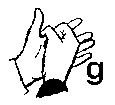

AHash mode:
('d', 11)
('x', 8)
('h', 10)
('n', 10)
('v', 8)
('k', 10)
('g', 0)
('y', 13)
('t', 12)
('j', 7)
('a', 13)
('b', 9)
('u', 9)
('p', 7)
('r', 9)
('e', 12)
('l', 7)
('o', 10)
('s', 6)
('w', 9)
('m', 11)
('z', 10)
('c', 8)
('i', 6)
('q', 15)
('f', 11)
PHash mode:
('d', 30)
('x', 19)
('h', 24)
('n', 26)
('v', 24)
('k', 27)
('g', 0)
('y', 24)
('t', 23)
('j', 17)
('a', 26)
('b', 21)
('u', 24)
('p', 20)
('r', 26)
('e', 27)
('l', 19)
('o', 21)
('s', 26)
('w', 17)
('m', 21)
('z', 27)
('c', 18)
('i', 24)
('q', 20)
('f', 28)
DHash mode:
('d', 10)
('x', 7)
('h', 10)
('n', 10)
('v', 8)
('k', 7)
('g', 0)
('y', 13)
('t', 12)
('j', 5)
('a', 13)
('b', 9)
('u', 8)
('p', 6)
('r', 9)
('e', 13)
('l', 7)
('o', 10)
('s', 6)
('w', 9)
('m', 9)
('z', 8)
('c', 8)
('i', 6)
('q', 15)
('f', 9)
NCC mode:
('d', 0.88837036910533129)
('x', 0.88341841555853551)
('h', 0.88417831620777099)
('n', 0.89472649330527732)
('v', 0.88886653637280078)
('k', 0.88115263879666916)
('g', 0.99999999999997879)
('y', 0.89107776

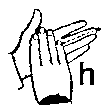

AHash mode:
('d', 7)
('x', 10)
('h', 0)
('n', 8)
('v', 10)
('k', 10)
('g', 10)
('y', 11)
('t', 10)
('j', 9)
('a', 11)
('b', 7)
('u', 9)
('p', 7)
('r', 9)
('e', 14)
('l', 5)
('o', 14)
('s', 8)
('w', 9)
('m', 9)
('z', 10)
('c', 10)
('i', 8)
('q', 7)
('f', 9)
PHash mode:
('d', 20)
('x', 25)
('h', 0)
('n', 20)
('v', 28)
('k', 19)
('g', 24)
('y', 30)
('t', 19)
('j', 21)
('a', 22)
('b', 21)
('u', 26)
('p', 30)
('r', 28)
('e', 21)
('l', 21)
('o', 31)
('s', 22)
('w', 23)
('m', 17)
('z', 27)
('c', 30)
('i', 32)
('q', 16)
('f', 22)
DHash mode:
('d', 6)
('x', 11)
('h', 0)
('n', 8)
('v', 10)
('k', 9)
('g', 10)
('y', 11)
('t', 10)
('j', 7)
('a', 9)
('b', 7)
('u', 8)
('p', 6)
('r', 9)
('e', 13)
('l', 5)
('o', 14)
('s', 8)
('w', 9)
('m', 9)
('z', 10)
('c', 10)
('i', 8)
('q', 7)
('f', 9)
NCC mode:
('d', 0.88349858580205876)
('x', 0.88812587348818761)
('h', 1.0000000000000171)
('n', 0.88627282011019415)
('v', 0.88300036992010877)
('k', 0.88765487001467769)
('g', 0.88300025303215668)
('y', 0.87887579916

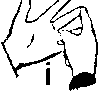

AHash mode:
('d', 9)
('x', 6)
('h', 8)
('n', 6)
('v', 8)
('k', 12)
('g', 6)
('y', 9)
('t', 10)
('j', 9)
('a', 13)
('b', 9)
('u', 7)
('p', 5)
('r', 7)
('e', 12)
('l', 7)
('o', 10)
('s', 4)
('w', 7)
('m', 11)
('z', 8)
('c', 4)
('i', 0)
('q', 13)
('f', 9)
PHash mode:
('d', 22)
('x', 19)
('h', 32)
('n', 20)
('v', 28)
('k', 19)
('g', 24)
('y', 22)
('t', 27)
('j', 23)
('a', 26)
('b', 17)
('u', 20)
('p', 16)
('r', 26)
('e', 31)
('l', 21)
('o', 25)
('s', 24)
('w', 25)
('m', 25)
('z', 23)
('c', 18)
('i', 0)
('q', 32)
('f', 26)
DHash mode:
('d', 8)
('x', 5)
('h', 8)
('n', 6)
('v', 8)
('k', 9)
('g', 6)
('y', 9)
('t', 10)
('j', 7)
('a', 11)
('b', 7)
('u', 6)
('p', 4)
('r', 7)
('e', 11)
('l', 7)
('o', 10)
('s', 4)
('w', 7)
('m', 9)
('z', 6)
('c', 4)
('i', 0)
('q', 13)
('f', 7)
NCC mode:
('d', 0.89566791239763699)
('x', 0.87005866090066997)
('h', 0.87655359113169351)
('n', 0.89286972752734428)
('v', 0.8817067392648652)
('k', 0.90086331507199569)
('g', 0.87746030942872877)
('y', 0.88162335099951172)


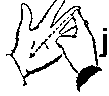

AHash mode:
('d', 10)
('x', 9)
('h', 9)
('n', 9)
('v', 7)
('k', 9)
('g', 7)
('y', 14)
('t', 15)
('j', 0)
('a', 14)
('b', 10)
('u', 10)
('p', 6)
('r', 8)
('e', 13)
('l', 8)
('o', 13)
('s', 9)
('w', 10)
('m', 10)
('z', 11)
('c', 9)
('i', 9)
('q', 12)
('f', 12)
PHash mode:
('d', 27)
('x', 18)
('h', 21)
('n', 27)
('v', 25)
('k', 22)
('g', 17)
('y', 27)
('t', 30)
('j', 0)
('a', 21)
('b', 24)
('u', 25)
('p', 23)
('r', 21)
('e', 28)
('l', 18)
('o', 26)
('s', 25)
('w', 30)
('m', 18)
('z', 26)
('c', 27)
('i', 23)
('q', 29)
('f', 27)
DHash mode:
('d', 7)
('x', 8)
('h', 7)
('n', 7)
('v', 5)
('k', 6)
('g', 5)
('y', 12)
('t', 13)
('j', 0)
('a', 12)
('b', 8)
('u', 7)
('p', 5)
('r', 8)
('e', 12)
('l', 8)
('o', 11)
('s', 7)
('w', 8)
('m', 6)
('z', 7)
('c', 7)
('i', 7)
('q', 12)
('f', 8)
NCC mode:
('d', 0.89424417946011692)
('x', 0.87603026403329654)
('h', 0.88146996583389703)
('n', 0.88531856763099137)
('v', 0.88275141680181568)
('k', 0.90322204853578569)
('g', 0.88743444256581516)
('y', 0.87276280213

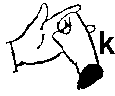

AHash mode:
('d', 11)
('x', 14)
('h', 10)
('n', 12)
('v', 10)
('k', 0)
('g', 10)
('y', 15)
('t', 12)
('j', 9)
('a', 11)
('b', 11)
('u', 13)
('p', 9)
('r', 13)
('e', 10)
('l', 11)
('o', 14)
('s', 10)
('w', 9)
('m', 11)
('z', 14)
('c', 10)
('i', 12)
('q', 13)
('f', 13)
PHash mode:
('d', 21)
('x', 26)
('h', 19)
('n', 23)
('v', 25)
('k', 0)
('g', 27)
('y', 25)
('t', 20)
('j', 22)
('a', 19)
('b', 18)
('u', 19)
('p', 17)
('r', 27)
('e', 22)
('l', 20)
('o', 30)
('s', 25)
('w', 22)
('m', 18)
('z', 26)
('c', 27)
('i', 19)
('q', 27)
('f', 21)
DHash mode:
('d', 9)
('x', 10)
('h', 9)
('n', 9)
('v', 9)
('k', 0)
('g', 7)
('y', 12)
('t', 11)
('j', 6)
('a', 12)
('b', 10)
('u', 9)
('p', 7)
('r', 10)
('e', 10)
('l', 10)
('o', 11)
('s', 7)
('w', 8)
('m', 10)
('z', 11)
('c', 9)
('i', 9)
('q', 12)
('f', 8)
NCC mode:
('d', 0.90444605091474783)
('x', 0.8726380470982209)
('h', 0.89028213993480765)
('n', 0.88926387660076522)
('v', 0.88616287339145217)
('k', 1.0000000000000087)
('g', 0.88204879664816027)
('y', 

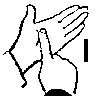

AHash mode:
('d', 10)
('x', 11)
('h', 5)
('n', 9)
('v', 11)
('k', 11)
('g', 7)
('y', 12)
('t', 11)
('j', 8)
('a', 14)
('b', 12)
('u', 10)
('p', 6)
('r', 10)
('e', 15)
('l', 0)
('o', 13)
('s', 7)
('w', 10)
('m', 12)
('z', 9)
('c', 9)
('i', 7)
('q', 8)
('f', 12)
PHash mode:
('d', 19)
('x', 26)
('h', 21)
('n', 25)
('v', 25)
('k', 20)
('g', 19)
('y', 25)
('t', 24)
('j', 18)
('a', 25)
('b', 20)
('u', 27)
('p', 17)
('r', 21)
('e', 28)
('l', 0)
('o', 26)
('s', 21)
('w', 24)
('m', 22)
('z', 22)
('c', 27)
('i', 21)
('q', 25)
('f', 23)
DHash mode:
('d', 9)
('x', 12)
('h', 5)
('n', 9)
('v', 11)
('k', 10)
('g', 7)
('y', 12)
('t', 11)
('j', 8)
('a', 12)
('b', 10)
('u', 9)
('p', 7)
('r', 10)
('e', 14)
('l', 0)
('o', 13)
('s', 7)
('w', 10)
('m', 10)
('z', 9)
('c', 9)
('i', 7)
('q', 8)
('f', 10)
NCC mode:
('d', 0.88549260550905406)
('x', 0.89373380788536028)
('h', 0.9021215444747066)
('n', 0.89880512710877014)
('v', 0.90061642208823678)
('k', 0.89145225542385642)
('g', 0.89113799754723599)
('y', 0.888

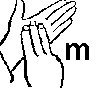

AHash mode:
('d', 12)
('x', 11)
('h', 9)
('n', 9)
('v', 13)
('k', 11)
('g', 11)
('y', 14)
('t', 15)
('j', 10)
('a', 12)
('b', 6)
('u', 8)
('p', 10)
('r', 12)
('e', 9)
('l', 12)
('o', 15)
('s', 11)
('w', 10)
('m', 0)
('z', 13)
('c', 13)
('i', 11)
('q', 10)
('f', 14)
PHash mode:
('d', 25)
('x', 20)
('h', 17)
('n', 21)
('v', 29)
('k', 18)
('g', 21)
('y', 25)
('t', 20)
('j', 18)
('a', 23)
('b', 16)
('u', 17)
('p', 25)
('r', 29)
('e', 18)
('l', 22)
('o', 30)
('s', 25)
('w', 20)
('m', 0)
('z', 20)
('c', 27)
('i', 25)
('q', 21)
('f', 25)
DHash mode:
('d', 11)
('x', 10)
('h', 9)
('n', 7)
('v', 11)
('k', 10)
('g', 9)
('y', 12)
('t', 15)
('j', 6)
('a', 10)
('b', 6)
('u', 5)
('p', 7)
('r', 10)
('e', 8)
('l', 10)
('o', 13)
('s', 9)
('w', 10)
('m', 0)
('z', 9)
('c', 11)
('i', 9)
('q', 8)
('f', 10)
NCC mode:
('d', 0.87775633089984373)
('x', 0.88002086356890752)
('h', 0.88250709279606288)
('n', 0.90825610698096115)
('v', 0.89588746302853461)
('k', 0.88425771624440908)
('g', 0.88667329534107342)
('y',

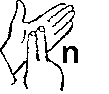

AHash mode:
('d', 11)
('x', 6)
('h', 8)
('n', 0)
('v', 10)
('k', 12)
('g', 10)
('y', 13)
('t', 12)
('j', 9)
('a', 15)
('b', 11)
('u', 7)
('p', 7)
('r', 7)
('e', 12)
('l', 9)
('o', 12)
('s', 6)
('w', 9)
('m', 9)
('z', 12)
('c', 6)
('i', 6)
('q', 9)
('f', 11)
PHash mode:
('d', 24)
('x', 17)
('h', 20)
('n', 0)
('v', 28)
('k', 23)
('g', 26)
('y', 28)
('t', 19)
('j', 27)
('a', 24)
('b', 21)
('u', 18)
('p', 24)
('r', 26)
('e', 27)
('l', 25)
('o', 27)
('s', 14)
('w', 25)
('m', 21)
('z', 21)
('c', 22)
('i', 20)
('q', 20)
('f', 28)
DHash mode:
('d', 10)
('x', 7)
('h', 8)
('n', 0)
('v', 10)
('k', 9)
('g', 10)
('y', 13)
('t', 12)
('j', 7)
('a', 13)
('b', 9)
('u', 6)
('p', 6)
('r', 7)
('e', 11)
('l', 9)
('o', 12)
('s', 6)
('w', 9)
('m', 7)
('z', 10)
('c', 6)
('i', 6)
('q', 9)
('f', 9)
NCC mode:
('d', 0.8912381779333759)
('x', 0.89055439710655893)
('h', 0.88843394630884687)
('n', 1.0000000000000022)
('v', 0.9109440350917074)
('k', 0.88867678648459303)
('g', 0.89414709443353324)
('y', 0.896890490108

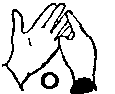

AHash mode:
('d', 15)
('x', 10)
('h', 14)
('n', 12)
('v', 12)
('k', 14)
('g', 10)
('y', 13)
('t', 18)
('j', 13)
('a', 15)
('b', 13)
('u', 11)
('p', 11)
('r', 11)
('e', 16)
('l', 13)
('o', 0)
('s', 8)
('w', 13)
('m', 15)
('z', 14)
('c', 12)
('i', 10)
('q', 17)
('f', 13)
PHash mode:
('d', 27)
('x', 20)
('h', 31)
('n', 27)
('v', 21)
('k', 30)
('g', 21)
('y', 17)
('t', 32)
('j', 26)
('a', 23)
('b', 28)
('u', 25)
('p', 23)
('r', 27)
('e', 26)
('l', 26)
('o', 0)
('s', 23)
('w', 26)
('m', 30)
('z', 24)
('c', 23)
('i', 25)
('q', 25)
('f', 21)
DHash mode:
('d', 14)
('x', 9)
('h', 14)
('n', 12)
('v', 12)
('k', 11)
('g', 10)
('y', 13)
('t', 18)
('j', 11)
('a', 13)
('b', 13)
('u', 12)
('p', 10)
('r', 11)
('e', 15)
('l', 13)
('o', 0)
('s', 8)
('w', 13)
('m', 13)
('z', 14)
('c', 12)
('i', 10)
('q', 17)
('f', 11)
NCC mode:
('d', 0.88077561945069893)
('x', 0.87552511026411994)
('h', 0.86717123187462986)
('n', 0.87901839048654495)
('v', 0.87582210223829438)
('k', 0.87653682096989871)
('g', 0.8748802087

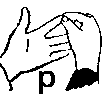

AHash mode:
('d', 8)
('x', 9)
('h', 7)
('n', 7)
('v', 7)
('k', 9)
('g', 7)
('y', 8)
('t', 9)
('j', 6)
('a', 12)
('b', 8)
('u', 6)
('p', 0)
('r', 6)
('e', 11)
('l', 6)
('o', 11)
('s', 5)
('w', 4)
('m', 10)
('z', 9)
('c', 7)
('i', 5)
('q', 10)
('f', 6)
PHash mode:
('d', 28)
('x', 25)
('h', 30)
('n', 24)
('v', 24)
('k', 17)
('g', 20)
('y', 24)
('t', 21)
('j', 23)
('a', 26)
('b', 23)
('u', 22)
('p', 0)
('r', 22)
('e', 27)
('l', 17)
('o', 23)
('s', 22)
('w', 19)
('m', 25)
('z', 27)
('c', 24)
('i', 16)
('q', 26)
('f', 30)
DHash mode:
('d', 6)
('x', 7)
('h', 6)
('n', 6)
('v', 6)
('k', 7)
('g', 6)
('y', 7)
('t', 8)
('j', 5)
('a', 9)
('b', 5)
('u', 4)
('p', 0)
('r', 5)
('e', 9)
('l', 7)
('o', 10)
('s', 4)
('w', 3)
('m', 7)
('z', 6)
('c', 6)
('i', 4)
('q', 11)
('f', 3)
NCC mode:
('d', 0.88085010637394467)
('x', 0.8590442058490555)
('h', 0.85471201528856622)
('n', 0.86208313196351927)
('v', 0.86921440266325956)
('k', 0.88042128595571856)
('g', 0.87324141331705663)
('y', 0.85657670763075622)
('t',

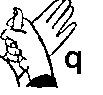

AHash mode:
('d', 12)
('x', 15)
('h', 7)
('n', 9)
('v', 13)
('k', 13)
('g', 15)
('y', 14)
('t', 15)
('j', 12)
('a', 16)
('b', 12)
('u', 10)
('p', 10)
('r', 14)
('e', 13)
('l', 8)
('o', 17)
('s', 11)
('w', 14)
('m', 10)
('z', 11)
('c', 13)
('i', 13)
('q', 0)
('f', 12)
PHash mode:
('d', 24)
('x', 23)
('h', 16)
('n', 20)
('v', 24)
('k', 27)
('g', 20)
('y', 28)
('t', 21)
('j', 29)
('a', 26)
('b', 25)
('u', 20)
('p', 26)
('r', 28)
('e', 21)
('l', 25)
('o', 25)
('s', 20)
('w', 21)
('m', 21)
('z', 19)
('c', 24)
('i', 32)
('q', 0)
('f', 18)
DHash mode:
('d', 11)
('x', 16)
('h', 7)
('n', 9)
('v', 13)
('k', 12)
('g', 15)
('y', 14)
('t', 15)
('j', 12)
('a', 14)
('b', 10)
('u', 9)
('p', 11)
('r', 14)
('e', 12)
('l', 8)
('o', 17)
('s', 11)
('w', 14)
('m', 8)
('z', 11)
('c', 13)
('i', 13)
('q', 0)
('f', 14)
NCC mode:
('d', 0.86032091186062831)
('x', 0.86298674324160296)
('h', 0.85522106684172672)
('n', 0.8817201484505498)
('v', 0.88268340052121619)
('k', 0.85960416339755241)
('g', 0.8875006854758351

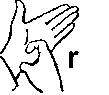

AHash mode:
('d', 8)
('x', 9)
('h', 9)
('n', 7)
('v', 7)
('k', 13)
('g', 9)
('y', 10)
('t', 11)
('j', 8)
('a', 12)
('b', 10)
('u', 8)
('p', 6)
('r', 0)
('e', 13)
('l', 10)
('o', 11)
('s', 5)
('w', 8)
('m', 12)
('z', 11)
('c', 9)
('i', 7)
('q', 14)
('f', 10)
PHash mode:
('d', 20)
('x', 21)
('h', 28)
('n', 26)
('v', 22)
('k', 27)
('g', 26)
('y', 20)
('t', 21)
('j', 21)
('a', 22)
('b', 27)
('u', 30)
('p', 22)
('r', 0)
('e', 21)
('l', 21)
('o', 27)
('s', 22)
('w', 21)
('m', 29)
('z', 25)
('c', 22)
('i', 26)
('q', 28)
('f', 26)
DHash mode:
('d', 9)
('x', 8)
('h', 9)
('n', 7)
('v', 7)
('k', 10)
('g', 9)
('y', 10)
('t', 11)
('j', 8)
('a', 10)
('b', 8)
('u', 7)
('p', 5)
('r', 0)
('e', 12)
('l', 10)
('o', 11)
('s', 5)
('w', 8)
('m', 10)
('z', 9)
('c', 9)
('i', 7)
('q', 14)
('f', 8)
NCC mode:
('d', 0.89191665263456488)
('x', 0.89838675178031169)
('h', 0.88806144895023198)
('n', 0.92524447899900331)
('v', 0.91038424113586425)
('k', 0.88714067471650915)
('g', 0.89170109601366032)
('y', 0.896640536

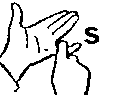

AHash mode:
('d', 9)
('x', 10)
('h', 8)
('n', 6)
('v', 6)
('k', 10)
('g', 6)
('y', 9)
('t', 10)
('j', 9)
('a', 11)
('b', 9)
('u', 7)
('p', 5)
('r', 5)
('e', 10)
('l', 7)
('o', 8)
('s', 0)
('w', 7)
('m', 11)
('z', 8)
('c', 4)
('i', 4)
('q', 11)
('f', 9)
PHash mode:
('d', 26)
('x', 25)
('h', 22)
('n', 14)
('v', 26)
('k', 25)
('g', 26)
('y', 24)
('t', 23)
('j', 25)
('a', 24)
('b', 23)
('u', 26)
('p', 22)
('r', 22)
('e', 21)
('l', 21)
('o', 23)
('s', 0)
('w', 25)
('m', 25)
('z', 21)
('c', 20)
('i', 24)
('q', 20)
('f', 22)
DHash mode:
('d', 8)
('x', 9)
('h', 8)
('n', 6)
('v', 6)
('k', 7)
('g', 6)
('y', 9)
('t', 10)
('j', 7)
('a', 9)
('b', 7)
('u', 6)
('p', 4)
('r', 5)
('e', 9)
('l', 7)
('o', 8)
('s', 0)
('w', 7)
('m', 9)
('z', 6)
('c', 4)
('i', 4)
('q', 11)
('f', 7)
NCC mode:
('d', 0.88469258616608248)
('x', 0.88870292253913274)
('h', 0.8825873360562142)
('n', 0.90371342650288444)
('v', 0.90369519503785201)
('k', 0.88745619558349598)
('g', 0.88263710719710786)
('y', 0.89040380919138562)
('t

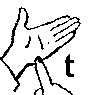

AHash mode:
('d', 13)
('x', 14)
('h', 10)
('n', 12)
('v', 12)
('k', 12)
('g', 12)
('y', 11)
('t', 0)
('j', 15)
('a', 15)
('b', 11)
('u', 13)
('p', 9)
('r', 11)
('e', 14)
('l', 11)
('o', 18)
('s', 10)
('w', 7)
('m', 15)
('z', 12)
('c', 10)
('i', 10)
('q', 15)
('f', 11)
PHash mode:
('d', 19)
('x', 26)
('h', 19)
('n', 19)
('v', 17)
('k', 20)
('g', 23)
('y', 27)
('t', 0)
('j', 30)
('a', 27)
('b', 18)
('u', 21)
('p', 21)
('r', 21)
('e', 20)
('l', 24)
('o', 32)
('s', 23)
('w', 10)
('m', 20)
('z', 24)
('c', 21)
('i', 27)
('q', 21)
('f', 21)
DHash mode:
('d', 12)
('x', 13)
('h', 10)
('n', 12)
('v', 12)
('k', 11)
('g', 12)
('y', 11)
('t', 0)
('j', 13)
('a', 15)
('b', 9)
('u', 12)
('p', 8)
('r', 11)
('e', 13)
('l', 11)
('o', 18)
('s', 10)
('w', 7)
('m', 15)
('z', 12)
('c', 10)
('i', 10)
('q', 15)
('f', 11)
NCC mode:
('d', 0.88491789727778747)
('x', 0.89214499907930933)
('h', 0.88897666181049662)
('n', 0.90561779838279777)
('v', 0.9081186309733742)
('k', 0.89308842266008548)
('g', 0.8954385529156

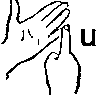

AHash mode:
('d', 10)
('x', 11)
('h', 9)
('n', 7)
('v', 9)
('k', 13)
('g', 9)
('y', 8)
('t', 13)
('j', 10)
('a', 12)
('b', 8)
('u', 0)
('p', 6)
('r', 8)
('e', 11)
('l', 10)
('o', 11)
('s', 7)
('w', 8)
('m', 8)
('z', 9)
('c', 9)
('i', 7)
('q', 10)
('f', 10)
PHash mode:
('d', 26)
('x', 23)
('h', 26)
('n', 18)
('v', 26)
('k', 19)
('g', 24)
('y', 26)
('t', 21)
('j', 25)
('a', 28)
('b', 17)
('u', 0)
('p', 22)
('r', 30)
('e', 23)
('l', 27)
('o', 25)
('s', 26)
('w', 21)
('m', 17)
('z', 21)
('c', 24)
('i', 20)
('q', 20)
('f', 22)
DHash mode:
('d', 8)
('x', 9)
('h', 8)
('n', 6)
('v', 8)
('k', 9)
('g', 8)
('y', 7)
('t', 12)
('j', 7)
('a', 9)
('b', 5)
('u', 0)
('p', 4)
('r', 7)
('e', 9)
('l', 9)
('o', 12)
('s', 6)
('w', 7)
('m', 5)
('z', 6)
('c', 8)
('i', 6)
('q', 9)
('f', 7)
NCC mode:
('d', 0.8923790382087019)
('x', 0.88062639198600579)
('h', 0.88656871089246025)
('n', 0.90375976804099101)
('v', 0.90469081487247016)
('k', 0.90010404405745126)
('g', 0.89674859017332675)
('y', 0.89815741429067453)

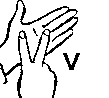

AHash mode:
('d', 7)
('x', 12)
('h', 10)
('n', 10)
('v', 0)
('k', 10)
('g', 8)
('y', 11)
('t', 12)
('j', 7)
('a', 9)
('b', 11)
('u', 9)
('p', 7)
('r', 7)
('e', 10)
('l', 11)
('o', 12)
('s', 6)
('w', 7)
('m', 13)
('z', 8)
('c', 6)
('i', 8)
('q', 13)
('f', 9)
PHash mode:
('d', 22)
('x', 27)
('h', 28)
('n', 28)
('v', 0)
('k', 25)
('g', 24)
('y', 24)
('t', 17)
('j', 25)
('a', 20)
('b', 29)
('u', 26)
('p', 24)
('r', 22)
('e', 21)
('l', 25)
('o', 21)
('s', 26)
('w', 19)
('m', 29)
('z', 21)
('c', 16)
('i', 28)
('q', 24)
('f', 18)
DHash mode:
('d', 6)
('x', 11)
('h', 10)
('n', 10)
('v', 0)
('k', 9)
('g', 8)
('y', 11)
('t', 12)
('j', 5)
('a', 11)
('b', 9)
('u', 8)
('p', 6)
('r', 7)
('e', 11)
('l', 11)
('o', 12)
('s', 6)
('w', 7)
('m', 11)
('z', 6)
('c', 6)
('i', 8)
('q', 13)
('f', 9)
NCC mode:
('d', 0.88219689633976506)
('x', 0.88428755404994797)
('h', 0.88354987949567465)
('n', 0.90987112925743407)
('v', 1.0000000000000122)
('k', 0.88490301638891489)
('g', 0.88868263215241128)
('y', 0.89167983

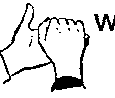

AHash mode:
('d', 10)
('x', 11)
('h', 9)
('n', 9)
('v', 7)
('k', 9)
('g', 9)
('y', 10)
('t', 7)
('j', 10)
('a', 12)
('b', 10)
('u', 8)
('p', 4)
('r', 8)
('e', 7)
('l', 10)
('o', 13)
('s', 7)
('w', 0)
('m', 10)
('z', 9)
('c', 7)
('i', 7)
('q', 14)
('f', 8)
PHash mode:
('d', 27)
('x', 24)
('h', 23)
('n', 25)
('v', 19)
('k', 22)
('g', 17)
('y', 21)
('t', 10)
('j', 30)
('a', 27)
('b', 22)
('u', 21)
('p', 19)
('r', 21)
('e', 22)
('l', 24)
('o', 26)
('s', 25)
('w', 0)
('m', 20)
('z', 26)
('c', 15)
('i', 25)
('q', 21)
('f', 21)
DHash mode:
('d', 9)
('x', 10)
('h', 9)
('n', 9)
('v', 7)
('k', 8)
('g', 9)
('y', 10)
('t', 7)
('j', 8)
('a', 12)
('b', 8)
('u', 7)
('p', 3)
('r', 8)
('e', 6)
('l', 10)
('o', 13)
('s', 7)
('w', 0)
('m', 10)
('z', 7)
('c', 7)
('i', 7)
('q', 14)
('f', 6)
NCC mode:
('d', 0.88300434426973218)
('x', 0.88242029176380299)
('h', 0.88155866417406537)
('n', 0.90201084414268651)
('v', 0.89094602838400028)
('k', 0.87816413531896587)
('g', 0.8900849264740317)
('y', 0.88734503857817

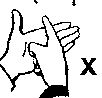

AHash mode:
('d', 13)
('x', 0)
('h', 10)
('n', 6)
('v', 12)
('k', 14)
('g', 8)
('y', 13)
('t', 14)
('j', 9)
('a', 17)
('b', 11)
('u', 11)
('p', 9)
('r', 9)
('e', 16)
('l', 11)
('o', 10)
('s', 10)
('w', 11)
('m', 11)
('z', 14)
('c', 10)
('i', 6)
('q', 15)
('f', 13)
PHash mode:
('d', 27)
('x', 0)
('h', 25)
('n', 17)
('v', 27)
('k', 26)
('g', 19)
('y', 19)
('t', 26)
('j', 18)
('a', 29)
('b', 22)
('u', 23)
('p', 25)
('r', 21)
('e', 30)
('l', 26)
('o', 20)
('s', 25)
('w', 24)
('m', 20)
('z', 26)
('c', 19)
('i', 19)
('q', 23)
('f', 27)
DHash mode:
('d', 11)
('x', 0)
('h', 11)
('n', 7)
('v', 11)
('k', 10)
('g', 7)
('y', 12)
('t', 13)
('j', 8)
('a', 14)
('b', 10)
('u', 9)
('p', 7)
('r', 8)
('e', 14)
('l', 12)
('o', 9)
('s', 9)
('w', 10)
('m', 10)
('z', 11)
('c', 9)
('i', 5)
('q', 16)
('f', 10)
NCC mode:
('d', 0.86639520627399225)
('x', 0.99999999999998135)
('h', 0.88921376332537894)
('n', 0.8899336523546193)
('v', 0.88509076630791617)
('k', 0.87159889146501446)
('g', 0.8830652974294344)
('y', 

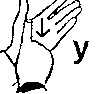

AHash mode:
('d', 12)
('x', 13)
('h', 11)
('n', 13)
('v', 11)
('k', 15)
('g', 13)
('y', 0)
('t', 11)
('j', 14)
('a', 12)
('b', 10)
('u', 8)
('p', 8)
('r', 10)
('e', 13)
('l', 12)
('o', 13)
('s', 9)
('w', 10)
('m', 14)
('z', 11)
('c', 13)
('i', 9)
('q', 14)
('f', 12)
PHash mode:
('d', 26)
('x', 19)
('h', 30)
('n', 28)
('v', 24)
('k', 25)
('g', 24)
('y', 0)
('t', 27)
('j', 27)
('a', 24)
('b', 25)
('u', 26)
('p', 24)
('r', 20)
('e', 19)
('l', 25)
('o', 17)
('s', 24)
('w', 21)
('m', 25)
('z', 27)
('c', 22)
('i', 22)
('q', 28)
('f', 24)
DHash mode:
('d', 11)
('x', 12)
('h', 11)
('n', 13)
('v', 11)
('k', 12)
('g', 13)
('y', 0)
('t', 11)
('j', 12)
('a', 10)
('b', 8)
('u', 7)
('p', 7)
('r', 10)
('e', 12)
('l', 12)
('o', 13)
('s', 9)
('w', 10)
('m', 12)
('z', 11)
('c', 13)
('i', 9)
('q', 14)
('f', 10)
NCC mode:
('d', 0.88461006586329971)
('x', 0.87742938596645814)
('h', 0.8806131073340715)
('n', 0.896890490108605)
('v', 0.89202425605173641)
('k', 0.88160867221291639)
('g', 0.89062923897307811)


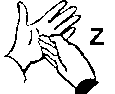

AHash mode:
('d', 7)
('x', 14)
('h', 10)
('n', 12)
('v', 8)
('k', 14)
('g', 10)
('y', 11)
('t', 12)
('j', 11)
('a', 13)
('b', 11)
('u', 9)
('p', 9)
('r', 11)
('e', 12)
('l', 9)
('o', 14)
('s', 8)
('w', 9)
('m', 13)
('z', 0)
('c', 8)
('i', 8)
('q', 11)
('f', 11)
PHash mode:
('d', 19)
('x', 26)
('h', 27)
('n', 21)
('v', 21)
('k', 26)
('g', 27)
('y', 27)
('t', 24)
('j', 26)
('a', 21)
('b', 22)
('u', 21)
('p', 27)
('r', 25)
('e', 24)
('l', 22)
('o', 24)
('s', 21)
('w', 26)
('m', 20)
('z', 0)
('c', 25)
('i', 23)
('q', 19)
('f', 21)
DHash mode:
('d', 6)
('x', 11)
('h', 10)
('n', 10)
('v', 6)
('k', 11)
('g', 8)
('y', 11)
('t', 12)
('j', 7)
('a', 11)
('b', 7)
('u', 6)
('p', 6)
('r', 9)
('e', 9)
('l', 9)
('o', 14)
('s', 6)
('w', 7)
('m', 9)
('z', 0)
('c', 6)
('i', 6)
('q', 11)
('f', 9)
NCC mode:
('d', 0.89522736311656992)
('x', 0.87071966472971662)
('h', 0.88004795928233048)
('n', 0.89771596321161584)
('v', 0.88933622545234536)
('k', 0.88767907166342375)
('g', 0.87953078000025053)
('y', 0.88378

In [20]:
def main():
    global RESULT, input_address
    display(DImage(filename=input_address))
    binarization(input_address)
    input_address = address_helper(input_address,'png')
    #preprocessing(img).save(input_address)
    separation(input_address, threshold)
    #images = os.listdir(finded_path)
    #for i in range(len(images)):
    #    try:
    #        separation(images[i], threshold)
    #    except IOError:
    #        pass  
    
    delete_trash(t_threshold)
    symbols = os.listdir(finded_path)
    count = 0
    for i in sorted(symbols):
        try: #check if files are images
            count+=1
            print('Processing:')
            display(DImage(filename=finded_path+i))
            compare_1toN(i)
            result_1toN()
            print_1toN()
            print('Processed: '+str(count)+'/'+str(len(symbols)))
        except IOError:
            pass
    print('Message: '+RESULT)
    RESULT = ''
    clean_folders()
main()